# Ultimatum game

**Inspired by:** Güth, W., Schmittberger, R., & Schwarze, B. (1982). _An experimental analysis of ultimatum bargaining._ Journal of economic behavior & organization, 3(4), 367-388.

This is classic economic game played between an "offerer" and a "receiver." The offerer is endowed with $100. They get to make an offer of some (or all) of the endowment to the receiver. The receiver can _accept_ the offer (in which case the deal goes through), or _reject_ it (in which case the deal falls through and nobody gets anything).

We will model a simple softmax-rational offerer-receiver pair and show that the expected rational behavior is for the offerer to offer only slightly more than zero. Interestingly, in practice people tend to offer closer to 50%. This disparity between theoretical prediction and empirical observation has been used to argue that people must be reasoning about some other factor—perhaps perceived fairness.

In [1]:
from memo import memo
import jax
import jax.numpy as np
from enum import IntEnum

Proposal = np.linspace(0, 1, 100)
class Decision(IntEnum):
    Accept = 0
    Reject = 1

@jax.jit
def payout_offerer(prop, dec):
    return np.array([
        1 - prop,  # if receiver accepts
        0          # if receiver rejects
    ])[dec]

@jax.jit
def payout_receiver(prop, dec):
    return np.array([
        prop,  # if receiver accepts
        0      # if receiver rejects
    ])[dec]

@memo  # probability that receiver accepts proposal
def receiver[prop: Proposal, dec: Decision]():
    receiver: knows(prop)
    receiver: chooses(dec in Decision, wpp=exp(50.0 * payout_receiver(prop, dec)))
    return Pr[ receiver.dec == dec ]

@memo  # probability that offerer proposes proposal
def offerer[prop: Proposal]():
    offerer: chooses(prop in Proposal, wpp=exp(50.0 * imagine[
        receiver: knows(prop),
        receiver: chooses(dec in Decision, wpp=receiver[prop, dec]()),
        E[ payout_offerer(prop, receiver.dec) ]
    ]))
    return Pr[ offerer.prop == prop ]

o = offerer()
r = receiver()

%timeit -r 10 -n 100 offerer().block_until_ready()
%timeit -r 10 -n 100 receiver().block_until_ready()

49.8 μs ± 3.09 μs per loop (mean ± std. dev. of 10 runs, 100 loops each)
10.7 μs ± 586 ns per loop (mean ± std. dev. of 10 runs, 100 loops each)


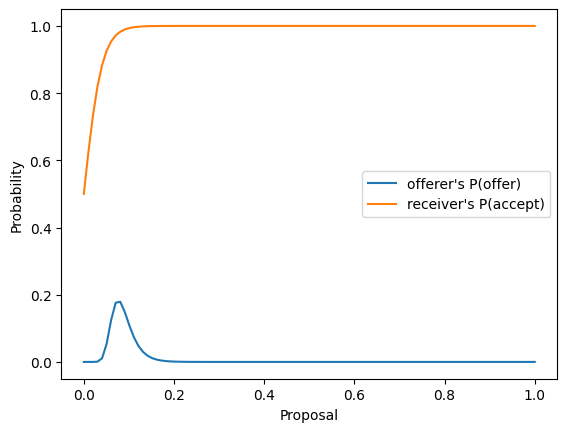

In [2]:
from matplotlib import pyplot as plt

plt.plot(Proposal, o, label="offerer's P(offer)")
plt.plot(Proposal, r[:, 0], label="receiver's P(accept)")

plt.xlabel('Proposal')
plt.ylabel('Probability')

plt.legend()